In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
scClass_path = !cd ../scClass_modelA;pwd
scClass_path = str(scClass_path.n)
import sys; sys.path.append(scClass_path)
import scClass
from scClass.main import Model

In [3]:
adata_bm = sc.read_h5ad("../dataset/BoneMarrow.h5ad")
adata_cb = sc.read_h5ad("../dataset/CordBlood.h5ad")
adata_tt = sc.read_h5ad("../dataset/HTD_Thymic.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata_bm.obs_names_make_unique()
adata_cb.obs_names_make_unique()
adata_tt.obs_names_make_unique()
adata_bm.var_names_make_unique()
adata_cb.var_names_make_unique()
adata_tt.var_names_make_unique()

/home/shhsu/.local/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(
/home/shhsu/.local/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [5]:
adata_bm = adata_bm[adata_bm.obs['modelA id']!=-1,:]
adata_cb = adata_cb[adata_cb.obs['modelA id']!=-1,:]
adata_tt = adata_tt[adata_tt.obs['modelA id']!=-1,:]

In [6]:
gene = np.array([g[:15] for g in adata_tt.var['ensembl_ids']])
adata_tt = scClass.transmodel(adata_tt,gene=gene,gene_ref='ensembl_ids')
adata_tt.var = adata_bm.var

/home/shhsu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


get gene seq...
0% 8% 17% 25% 34% 42% 51% 59% 68% 77% 85% 94% 
Of 58347 genes in the input file, 45471 were found in the training set of 45468 genes.
mapping to model...
0% 51% 

In [7]:
adata_bm = scClass.normalize_simple(adata_bm)
adata_cb = scClass.normalize_simple(adata_cb)
adata_tt = scClass.normalize_simple(adata_tt)

In [8]:
adata = sc.AnnData.concatenate(adata_bm,adata_cb,adata_tt)

In [9]:
adata.X

<612580x45468 sparse matrix of type '<class 'numpy.float32'>'
	with 711491259 stored elements in Compressed Sparse Row format>

In [10]:
adata.write_h5ad('thymic_tmp.h5ad')

... storing 'cell_names' as categorical
... storing 'input_id' as categorical
... storing 'label' as categorical
... storing 'u_CellID' as categorical
... storing 'transfer cell type' as categorical
... storing 'origin cell type' as categorical


## Cluster

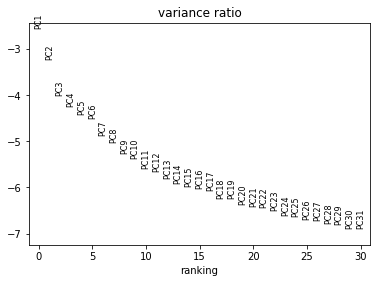

In [11]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2022-03-11 13:30:05.894659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 13:30:05.894761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


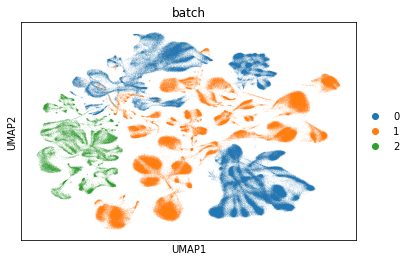

In [13]:
sc.pl.umap(adata,color='batch')

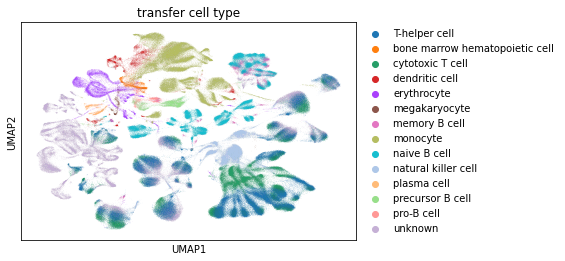

In [14]:
sc.pl.umap(adata,color='transfer cell type')

## Harmony

In [15]:
sc.external.pp.harmony_integrate(adata, 'batch')

2022-03-11 13:55:56,656 - harmonypy - INFO - Iteration 1 of 10
2022-03-11 14:04:11,346 - harmonypy - INFO - Iteration 2 of 10
2022-03-11 14:12:22,517 - harmonypy - INFO - Iteration 3 of 10
2022-03-11 14:20:32,435 - harmonypy - INFO - Iteration 4 of 10
2022-03-11 14:28:42,936 - harmonypy - INFO - Iteration 5 of 10
2022-03-11 14:36:51,679 - harmonypy - INFO - Iteration 6 of 10
2022-03-11 14:43:54,031 - harmonypy - INFO - Iteration 7 of 10
2022-03-11 14:52:04,797 - harmonypy - INFO - Iteration 8 of 10
2022-03-11 14:59:50,885 - harmonypy - INFO - Iteration 9 of 10
2022-03-11 15:04:57,438 - harmonypy - INFO - Iteration 10 of 10
2022-03-11 15:10:50,484 - harmonypy - INFO - Stopped before convergence


In [16]:
adata.write_h5ad('harmony_HTD_Thymic.h5ad')

In [17]:
# adata2 = sc.read_h5ad("harmony_HTD_Thymic.h5ad")

In [18]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

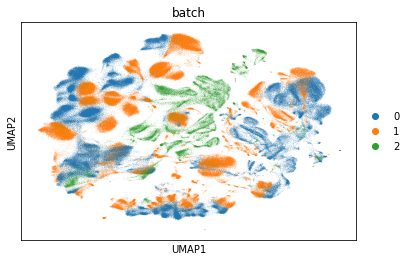

In [19]:
sc.pl.umap(adata,color='batch')

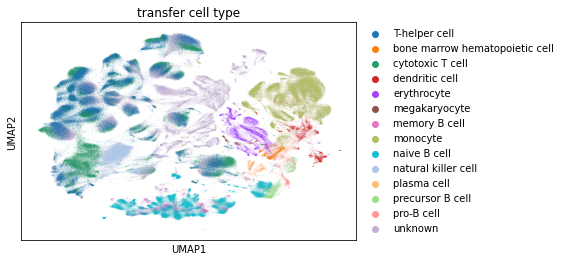

In [20]:
sc.pl.umap(adata,color='transfer cell type')

## Training

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import warnings;warnings.filterwarnings("ignore")

In [2]:
scClass_path = !cd ../scClass_modelA;pwd
scClass_path = str(scClass_path.n)
import sys; sys.path.append(scClass_path)
import scClass
from scClass.main import Model

In [3]:
adata = sc.read_h5ad("harmony_HTD_Thymic.h5ad")
adata.X

<500796x45468 sparse matrix of type '<class 'numpy.float32'>'
	with 537081205 stored elements in Compressed Sparse Row format>

In [4]:
adata = adata[adata.obs['modelA id']!=-1,:]

In [5]:
adata.write_h5ad('harmony_HTD_Thymic.h5ad')

In [6]:
scClass.main.EPOCH = 30

In [7]:
dataset = scClass.npz_dataloader(adata)

Trying to set attribute `.obs` of view, copying.


In [8]:
model = scClass.Model()

In [9]:
scClass.training(dataset,model)

1 11 21 31 41 51 61 epoch 0 	| loss:1.71908760 | training accuracy:0.48286273| loss:1.71579635 | validation accuracy:0.48455990
1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 epoch 5 	| loss:0.41300109 | training accuracy:0.87181558| loss:0.41420448 | validation accuracy:0.86998824
1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 epoch 10 	| loss:0.33157328 | training accuracy:0.88850056| loss:0.33328712 | validation accuracy:0.88715078
1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 epoch 15 	| loss:0.30354634 | training accuracy:0.89478569| loss:0.30571568 | validation accuracy:0.89338046
1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 1 11 21 31 41 51 61 epoch 20 	| loss:0.28926343 | training accuracy:0.89804280| loss:0.29176211 | validation accuracy:0.89670157
1 11 21 31 41 51 61 1 11 21 31 41 51 

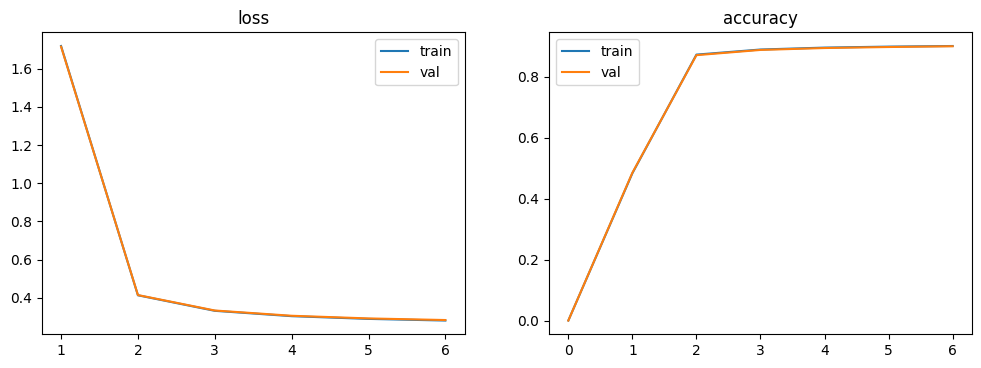

In [10]:
scClass.plot_learning_curve()  

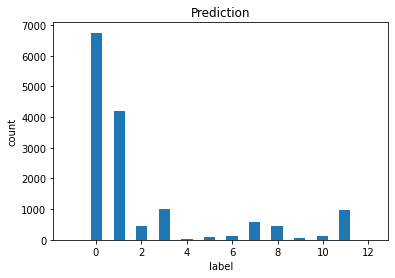

In [11]:
scClass.main.threshold = [np.NAN]*13
y_pred = scClass.predict_batch(dataset.test_x,model)

## Verity Testing Data

,label
-1,unknown
0,T-helper cell
1,cytotoxic T cell
2,memory B cell
3,naive B cell
4,plasma cell
5,precursor B cell
6,pro-B cell
7,natural killer cell
8,erythrocyte

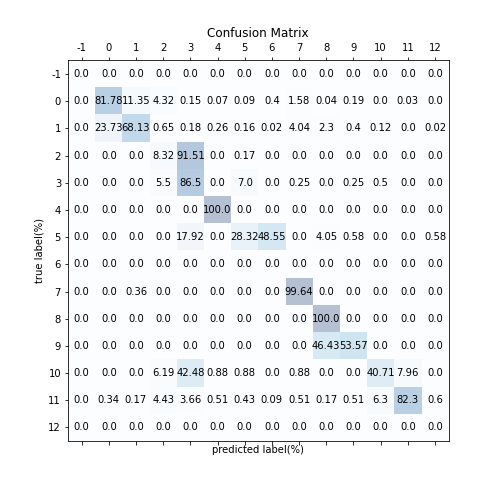

In [12]:
fig = scClass.confusion_matrix(y_pred=y_pred,y_true=dataset.test_y)
scClass.figure_html(fig)

In [13]:
y_pred[y_pred==2] = 3 
y_true = np.array(dataset.test_y)
scClass.plot_performance(y_pred=y_pred,y_true=y_true)

,Performance,Value
0,accuary,0.740136
1,precision,0.746445
2,recall,0.545076
3,f1-score,0.586323


## Verity Training Data

In [ ]:
y_pred = scClass.predict_batch(dataset.val_x,model)
scClass.confusion_matrix(y_pred=y_pred,y_true=dataset.val_y)

In [ ]:
scClass.plot_performance(y_pred=y_pred,y_true=np.array(dataset.val_y))